### Step 1: Import Libraries

In [1]:
import numpy as np
import os, glob

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from skimage.io import imread
from skimage.feature import hog
from skimage.transform import resize
from skimage import exposure


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import seaborn as sns


### Step 2: Load and preprocess the fish dataset

In [2]:
data_dir = r"D:\VS projects\fish_classifier\Fish_Dataset"

X = []
y = []

for class_name in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, class_name)

    # skip GT folders
    if not os.path.isdir(class_folder) or class_name.endswith("GT"):
        continue
    
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)

        try:
            img = imread(img_path)   # load image
            img = resize(img, (128,128), anti_aliasing=True)
            X.append(img)            # append image as is
            y.append(class_name)     # append label
        except:
            print("Error loading:", img_path)



X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)   # (num_samples, H, W)
print("y shape:", y.shape)   # (num_samples,)

X shape: (9000, 128, 128, 3)
y shape: (9000,)


In [3]:
# Convert class names to numeric labels
classes = sorted(set(y))  # unique class names
class_to_idx = {c: i for i, c in enumerate(classes)}

# Apply mapping
y_num = np.array([class_to_idx[label] for label in y])


In [4]:
class_names = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

def plot_training_curves(history, title, fold_no):
    plt.figure(figsize=(14, 5))

    # --- Plot Accuracy ---
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} (Best Fold: {fold_no}) - Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Plot Loss ---
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} (Best Fold: {fold_no}) - Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

### Step 3: Building and Training the First CNN Model (Without Dropout)

In [ ]:
# --- Configuration ---
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
history_best_no_dropout = None
best_cnn_no_dropout = None
best_acc_no_dropout = 0.0
best_fold_no_dropout = 0  
best_y_pred_no_dropout = None
best_y_val_no_dropout = None
fold_no = 1

print("=== Starting Cross-Validation: Model WITHOUT Dropout ===")

for train_index, val_index in kfold.split(X, y_num):
    print(f"\nProcessing Fold {fold_no}...")
    
    # 1. Prepare Data
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold = to_categorical(y_num[train_index], 9)
    y_val_fold = to_categorical(y_num[val_index], 9)
    
    # 2. Build Model
    model_a = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        MaxPooling2D((2,2)),      
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(9, activation='softmax')
    ])
    
    model_a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # 3. Train
    hist_a = model_a.fit(X_train_fold, y_train_fold, epochs=10, batch_size=64, validation_data=(X_val_fold, y_val_fold),verbose=0)
    
    # 4. Evaluate
    loss_a, acc_a = model_a.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"  > Accuracy: {acc_a*100:.2f}%")
    
    y_pred = model_a.predict(X_val_fold)

    # 5. Save if Best
    if acc_a > best_acc_no_dropout:
        best_acc_no_dropout = acc_a
        best_cnn_no_dropout = model_a
        history_best_no_dropout = hist_a
        best_fold_no_dropout = fold_no 
        best_y_pred_no_dropout = y_pred
        best_y_val_no_dropout = y_val_fold
        
    fold_no += 1

print(f"\n[No Dropout] Best Accuracy: {best_acc_no_dropout*100:.2f}% (Achieved in Fold {best_fold_no_dropout})")

=== Starting Cross-Validation: Model WITHOUT Dropout ===

Processing Fold 1...


c:\Users\PCD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  > Accuracy: 96.83%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Processing Fold 2...
  > Accuracy: 98.17%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Processing Fold 3...
  > Accuracy: 98.44%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Processing Fold 4...
  > Accuracy: 94.50%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Processing Fold 5...
  > Accuracy: 97.22%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

[No Dropout] Best Accuracy: 98.44% (Achieved in Fold 3)


In [6]:
best_cnn_no_dropout.save(f"cnn_no_dropout_fold02.h5")

### Step 4: Building and Training the First CNN Model  (with Dropout)

In [7]:
# --- Storage for Model B ---
history_best_with_dropout = None
best_cnn_with_dropout = None
best_acc_with_dropout = 0.0
best_fold_with_dropout = 0 
best_y_pred_with_dropout = None
best_y_val_with_dropout = None
fold_no = 1

print("\n=== Starting Cross-Validation: Model WITH Dropout ===")

for train_index, val_index in kfold.split(X, y_num):
    print(f"\nProcessing Fold {fold_no}...")
    
    # 1. Prepare Data
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold = to_categorical(y_num[train_index], 9)
    y_val_fold = to_categorical(y_num[val_index], 9)
    
    # 2. Build Model
    model_b = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(9, activation='softmax')
    ])
    
    model_b.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # 3. Train
    hist_b = model_b.fit(X_train_fold, y_train_fold, epochs=10, batch_size=64, validation_data=(X_val_fold, y_val_fold), verbose=0)
    
    # 4. Evaluate
    loss_b, acc_b = model_b.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"  > Accuracy: {acc_b*100:.2f}%")
    
    y_pred = model_b.predict(X_val_fold)

    # 5. Save if Best
    if acc_b > best_acc_with_dropout:
        best_acc_with_dropout = acc_b
        best_cnn_with_dropout = model_b 
        history_best_with_dropout = hist_b
        best_fold_with_dropout = fold_no
        best_y_pred_with_dropout = y_pred
        best_y_val_with_dropout = y_val_fold
        
    fold_no += 1

print(f"\n[With Dropout] Best Accuracy: {best_acc_with_dropout*100:.2f}% (Achieved in Fold {best_fold_with_dropout})")


=== Starting Cross-Validation: Model WITH Dropout ===

Processing Fold 1...


c:\Users\PCD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  > Accuracy: 96.50%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Processing Fold 2...
  > Accuracy: 97.78%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Processing Fold 3...
  > Accuracy: 97.11%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Processing Fold 4...
  > Accuracy: 97.06%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Processing Fold 5...
  > Accuracy: 95.11%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

[With Dropout] Best Accuracy: 97.78% (Achieved in Fold 2)


In [8]:
best_cnn_with_dropout.save(f"cnn_with_dropout_fold02.h5")

### Step 5: Evaluating the Models and Plotting Training Curves

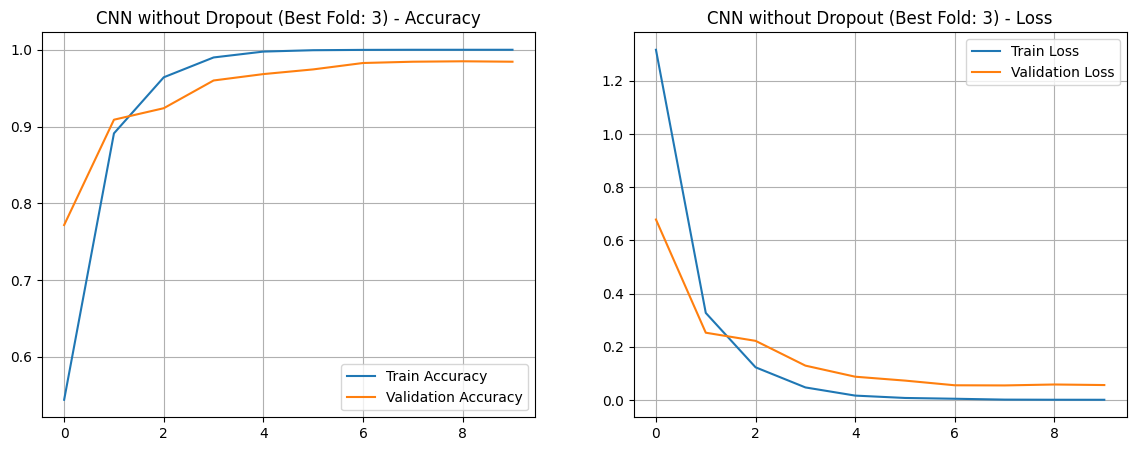

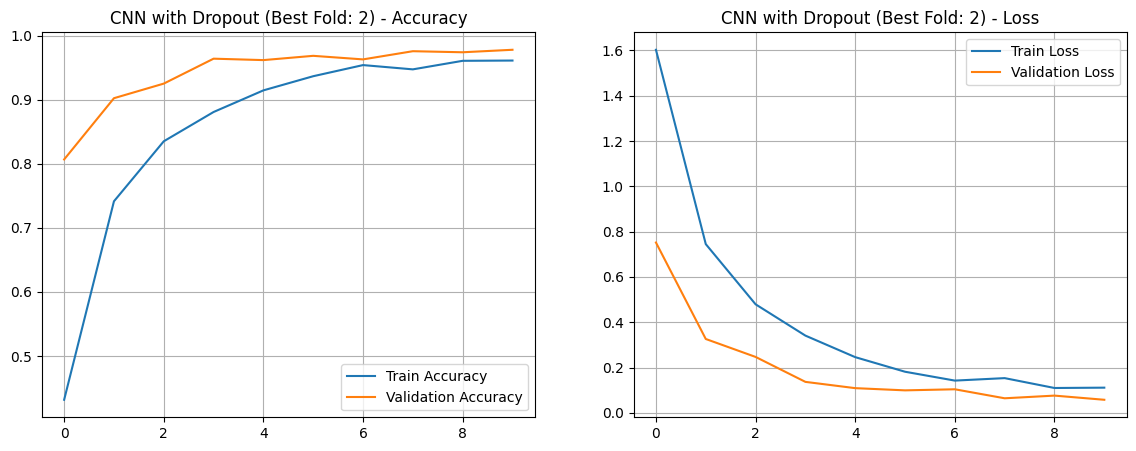

In [9]:
# Plot the training and validation accuracy and loss for the model without dropout
plot_training_curves(history_best_no_dropout, 'CNN without Dropout', best_fold_no_dropout)

# Plot the training and validation accuracy and loss for the model with dropout
plot_training_curves(history_best_with_dropout, 'CNN with Dropout', best_fold_with_dropout)

### Plotting Confusion Matrices for Both Models

explain which is better with/without dropout

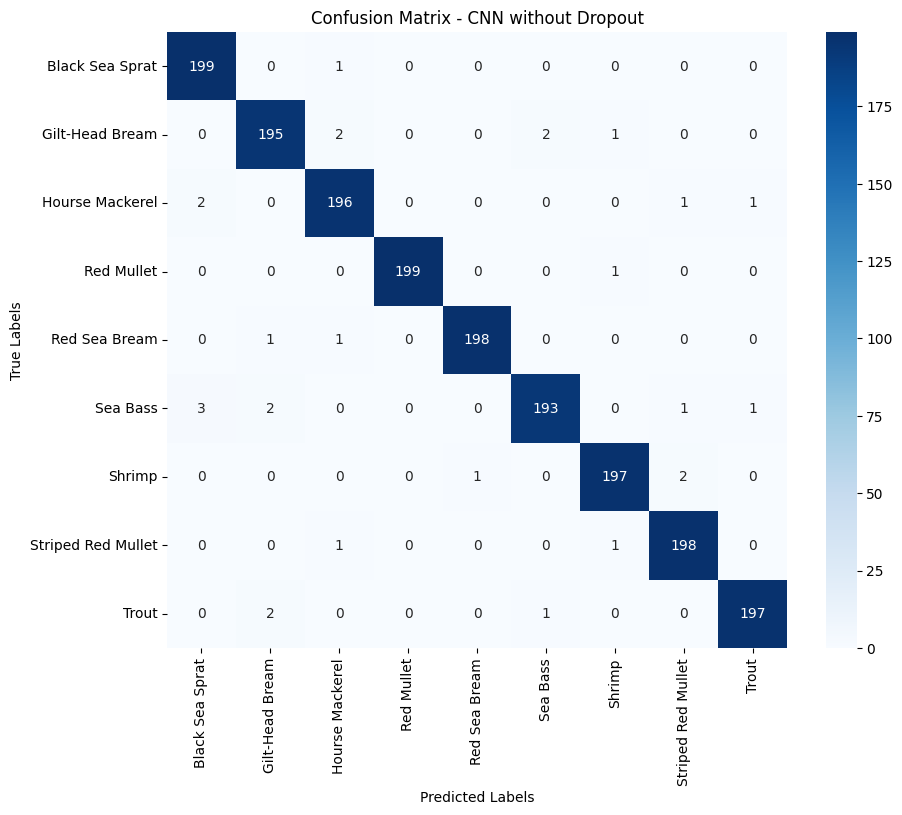

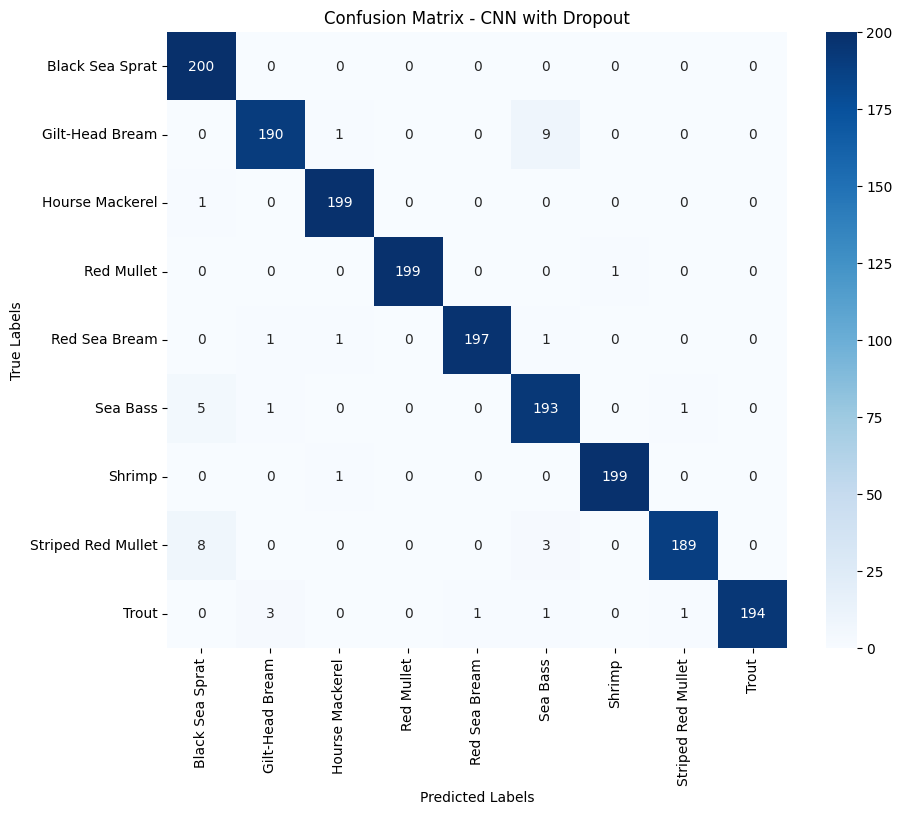

In [10]:
# Plot the confusion matrix for the model without dropout
plot_confusion_matrix(best_y_val_no_dropout, best_y_pred_no_dropout, 'Confusion Matrix - CNN without Dropout')

# Plot the confusion matrix for the model with dropout
plot_confusion_matrix(best_y_val_with_dropout, best_y_pred_with_dropout, 'Confusion Matrix - CNN with Dropout')


In [11]:
# Convert true and predicted probabilities to integers
y_true_with_dropout = np.argmax(best_y_val_with_dropout, axis=1)
y_pred_with_dropout = np.argmax(best_y_pred_with_dropout, axis=1)
y_true_no_dropout = np.argmax(best_y_val_no_dropout, axis=1)
y_pred_no_dropout = np.argmax(best_y_pred_no_dropout, axis=1)

print("CNN without Dropout Classification Report:\n")
print(classification_report(y_true_no_dropout, y_pred_no_dropout, target_names=class_names, digits=4))

print("CNN with Dropout Classification Report:\n")
print(classification_report(y_true_with_dropout, y_pred_with_dropout, target_names=class_names, digits=4))

CNN without Dropout Classification Report:

                    precision    recall  f1-score   support

   Black Sea Sprat     0.9755    0.9950    0.9851       200
   Gilt-Head Bream     0.9750    0.9750    0.9750       200
   Hourse Mackerel     0.9751    0.9800    0.9776       200
        Red Mullet     1.0000    0.9950    0.9975       200
     Red Sea Bream     0.9950    0.9900    0.9925       200
          Sea Bass     0.9847    0.9650    0.9747       200
            Shrimp     0.9850    0.9850    0.9850       200
Striped Red Mullet     0.9802    0.9900    0.9851       200
             Trout     0.9899    0.9850    0.9875       200

          accuracy                         0.9844      1800
         macro avg     0.9845    0.9844    0.9844      1800
      weighted avg     0.9845    0.9844    0.9844      1800

CNN with Dropout Classification Report:

                    precision    recall  f1-score   support

   Black Sea Sprat     0.9346    1.0000    0.9662       200
   Gilt-Hea

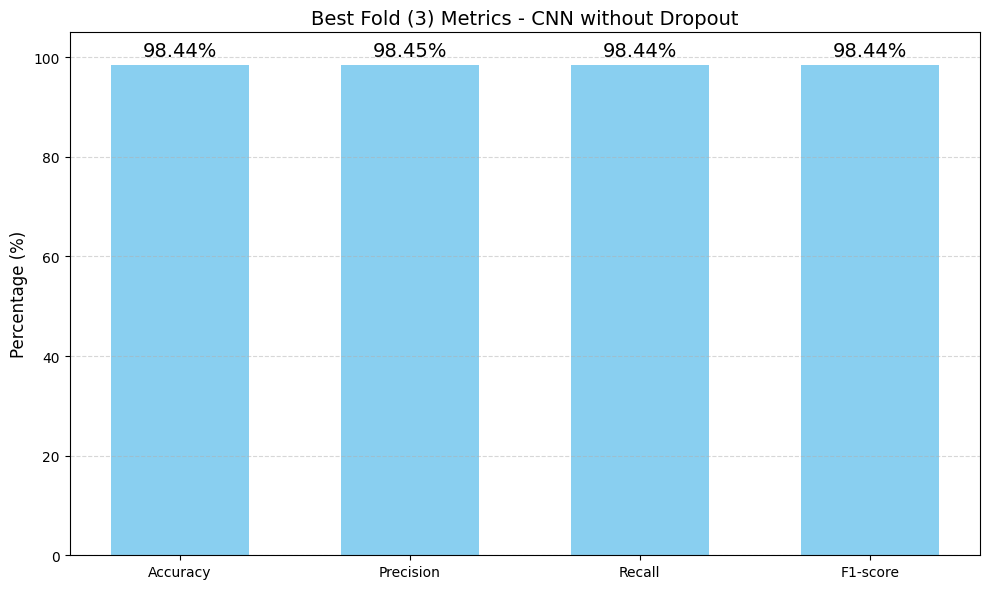

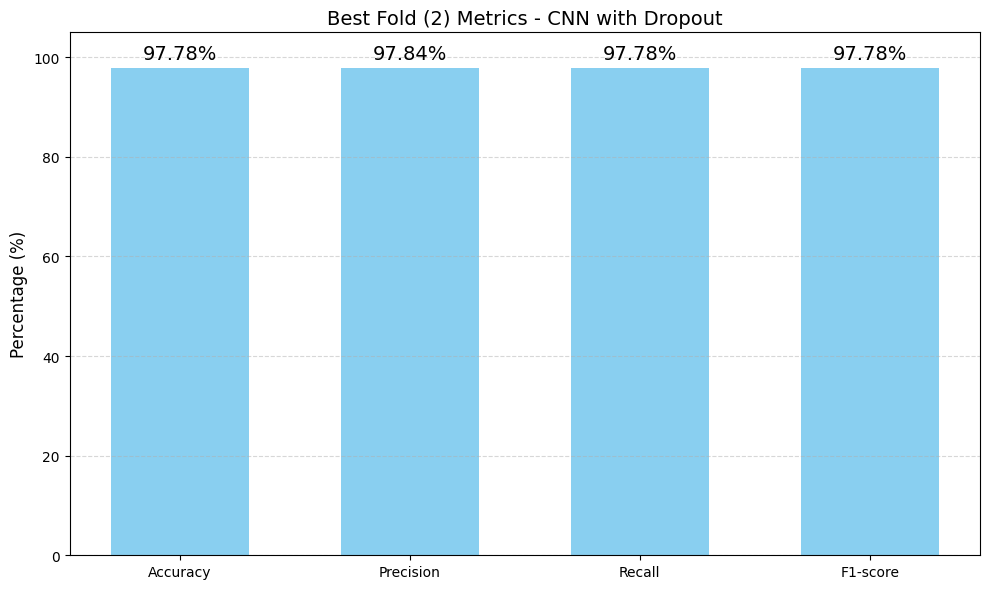

In [12]:
def plot_metrics_graph(metrics_values, title):
    # 1. Setup Data
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    
    # Check if input length matches expected metrics
    if len(metrics_values) != 4:
        print("Warning: Expected 4 metric values (Accuracy, Precision, Recall, F1).")

    # Convert values to percentages
    values_pct = [x * 100 for x in metrics_values]
    
    # 2. Create the Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars
    bars = ax.bar(metric_names, values_pct, color='#89CFF0', width=0.6, zorder=1)
    
    # 3. Add Value Labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=14, color='black')
    
    # 4. Styling
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_ylim(0, 105) 
    ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)
    
    plt.tight_layout()
    plt.show()

CNN_no = [0.9844 , 0.9845  ,  0.9844  ,  0.9844]
plot_metrics_graph(CNN_no, 'Best Fold (3) Metrics - CNN without Dropout') 

CNN_with = [0.9778 ,  0.9784 ,   0.9778  ,  0.9778]
plot_metrics_graph(CNN_with, 'Best Fold (2) Metrics - CNN with Dropout') 